1. https://antonsruberts.github.io/DNN-for-CLV/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data

In [4]:
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [5]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-xcauhnou
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-xcauhnou
  Resolved https://github.com/tensorflow/docs to commit 3eac15bae13ea389957e7eb499252ef5da6c9f01
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.4.30.68232-py3-none-any.whl size=182538 sha256=36dd88d9626b0acaf05f963e94459c092295ee5ff6e5219a4806abc6f323dbfe
  Stored in directory: /tmp/pip-ephem-wheel-cache-q47p79io/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [6]:
import tensorflow as tf
from tensorflow.keras import callbacks
import tensorflow_docs as tfdocs

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

# DATA

In [8]:
data = pd.read_csv('/content/drive/MyDrive/BA - Project 2/Data/online_retail_II.csv')
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [9]:
df = data.copy()

In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
#Datetime transformation
df['date'] = pd.to_datetime(df['InvoiceDate'].dt.date)
df['time'] = df['InvoiceDate'].dt.time
df['hour'] = df['time'].apply(lambda x: x.hour)
df['weekend'] = df['date'].apply(lambda x: x.weekday() in [5, 6])
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)
#Get revenue column
df['Revenue'] = df['Quantity'] * df['Price']


In [12]:
recency = df.groupby('Customer ID')['InvoiceDate'].max().rename('Recency')

# Tính Frequency bằng cách đếm số lượng hóa đơn cho mỗi khách hàng
frequency = df.groupby('Customer ID')['Invoice'].nunique().rename('Frequency')

# Tính Monetary bằng tổng giá trị hóa đơn cho mỗi khách hàng
monetary = df.groupby('Customer ID')['Revenue'].sum().rename('Monetary')

# Tạo DataFrame rfm_train từ các giá trị Recency, Frequency và Monetary
rfm_train = pd.concat([recency, frequency, monetary], axis=1)

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,date,time,hour,weekend,dayofweek,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01,07:45:00,7,False,1,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,07:45:00,7,False,1,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,07:45:00,7,False,1,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12-01,07:45:00,7,False,1,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01,07:45:00,7,False,1,30.0


In [ ]:
print(df['InvoiceDate'].min())
print(df['InvoiceDate'].max())

2009-12-01 07:45:00
2011-12-09 12:50:00


738 days 00:00:00


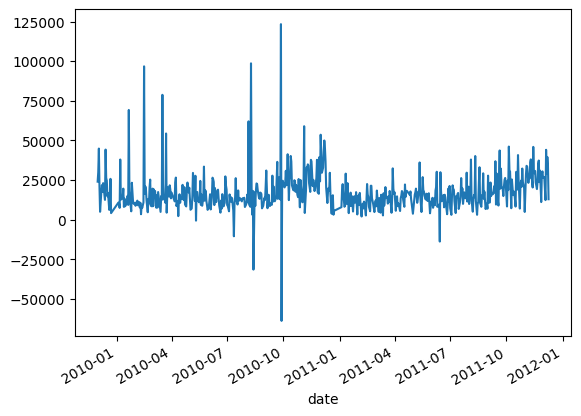

In [ ]:
#Plots a timeseries of total sales
df.groupby('date')['Quantity'].sum().plot()
#Prints the total number of days between start and end
print(df['date'].max() - df['date'].min())

1. Training Features Period - from 2010-01-01 until 2011-01-01
2. Training Target Period - from 2010-04-01 until 2011-04-01
3. Testing Features Period - from 2011-04-01 until 2011-09-10
4. Testing Target Period - from 2011-09-01 until 2011-12-09

In [13]:
def get_features(data, feature_start, feature_end, target_start, target_end):

    #Double check the periods length
    features_data = data.loc[(data.date >= feature_start) & (data.date <= feature_end), :]
    print(f'Using data from {(pd.to_datetime(feature_end) - pd.to_datetime(feature_start)).days} days')
    print(f'To predict {(pd.to_datetime(target_end) - pd.to_datetime(target_start)).days} days')

    #Transactions data features
    total_rev = features_data.groupby('Customer ID')['Revenue'].sum().rename('total_revenue')
    recency = (features_data.groupby('Customer ID')['date'].max() - features_data.groupby('Customer ID')['date'].min()).apply(lambda x: x.days).rename('recency')
    frequency = features_data.groupby('Customer ID')['Invoice'].count().rename('frequency')
    t = features_data.groupby('Customer ID')['date'].min().apply(lambda x: (datetime(2011, 6, 11) - x).days).rename('t')
    time_between = (t / frequency).rename('time_between')
    avg_basket_value = (total_rev / frequency).rename('avg_basket_value')
    avg_basket_size = (features_data.groupby('Customer ID')['Quantity'].sum() / frequency).rename('avg_basket_Size')
    returns = features_data.loc[features_data['Revenue'] < 0, :].groupby('Customer ID')['Invoice'].count().rename('num_returns')
    hour = features_data.groupby('Customer ID')['hour'].median().rename('purchase_hour_med')
    dow = features_data.groupby('Customer ID')['dayofweek'].median().rename('purchase_dow_med')
    weekend =  features_data.groupby('Customer ID')['weekend'].mean().rename('purchase_weekend_prop')
    train_data = pd.DataFrame(index = rfm_train.index)
    train_data = train_data.join([total_rev, recency, frequency, t, time_between, avg_basket_value, avg_basket_size, returns, hour, dow, weekend])
    train_data = train_data.fillna(0)

    #Target data
    target_data = data.loc[(data.date >= target_start) & (data.date <= target_end), :]
    target_quant = target_data.groupby(['Customer ID'])['date'].nunique()
    target_rev = target_data.groupby(['Customer ID'])['Revenue'].sum().rename('target_rev')
    train_data = train_data.join(target_rev).fillna(0)

    return train_data.iloc[:, :-1], train_data.iloc[:, -1] #X and Y



In [14]:
X_train, y_train = get_features(df, '2011-01-01', '2011-06-11', '2011-06-12', '2011-09-09')
X_test, y_test = get_features(df, '2011-04-02', '2011-09-10', '2011-09-11', '2011-12-09')

Using data from 161 days
To predict 89 days
Using data from 161 days
To predict 89 days


In [ ]:
X_train.head()

,total_revenue,recency,frequency,t,time_between,avg_basket_value,avg_basket_Size,num_returns,purchase_hour_med,purchase_dow_med,purchase_weekend_prop
Customer ID,,,,,,,,,,,
12346.0,0.00,0.0,2.0,144.0,72.000000,0.000000,0.000000,1.0,10.0,1.0,0.0
12347.0,1494.16,134.0,71.0,136.0,1.915493,21.044507,14.000000,0.0,13.0,3.0,0.0
12348.0,594.44,70.0,11.0,137.0,12.454545,54.040000,79.090909,0.0,10.0,1.0,0.0
12349.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
12350.0,334.40,0.0,17.0,129.0,7.588235,19.670588,11.588235,0.0,16.0,2.0,0.0


In [ ]:
y_train

Customer ID
12346.0      0.00
12347.0    584.91
12348.0      0.00
12349.0      0.00
12350.0      0.00
            ...  
18283.0    585.62
18284.0      0.00
18285.0      0.00
18286.0      0.00
18287.0      0.00
Name: target_rev, Length: 5942, dtype: float64

# DNN Model

In [16]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [17]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
186/186 [==============================] - 2s 5ms/step - loss: 1114675.5000 - val_loss: 3653257.2500
Epoch 2/100
186/186 [==============================] - 1s 4ms/step - loss: 774777.9375 - val_loss: 4213055.5000
Epoch 3/100
186/186 [==============================] - 1s 6ms/step - loss: 824199.3750 - val_loss: 3738204.2500
Epoch 4/100
186/186 [==============================] - 1s 5ms/step - loss: 772201.0625 - val_loss: 3916903.7500
Epoch 5/100
186/186 [==============================] - 0s 3ms/step - loss: 750178.3125 - val_loss: 2967750.7500
Epoch 6/100
186/186 [==============================] - 1s 3ms/step - loss: 783085.1250 - val_loss: 3275862.5000
Epoch 7/100
186/186 [==============================] - 1s 3ms/step - loss: 748878.1250 - val_loss: 3055019.7500
Epoch 8/100
186/186 [==============================] - 0s 3ms/step - loss: 673777.8750 - val_loss: 4010385.2500
Epoch 9/100
186/186 [==============================] - 1s 3ms/step - loss: 846703.3125 - val_loss: 4043

186/186 [==============================] - 0s 2ms/step
Total Sales Actual: 3167590.0
Total Sales Predicted: 1923765.0
Individual R2 score: 0.605188067899621
Individual Mean Absolute Error: 424.96891402384927
Individual Mean Squared Error: 3597224.6679413314
Individual Mean Absolute Percentage Error: 3.1266417311318374e+17


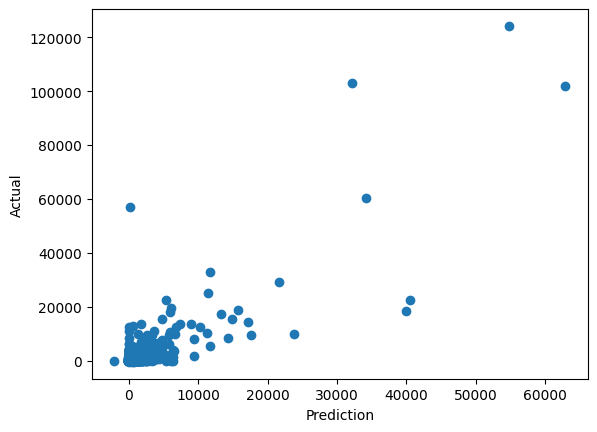

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate(actual, sales_prediction):
    print(f"Total Sales Actual: {np.round(actual.sum())}")
    print(f"Total Sales Predicted: {np.round(sales_prediction.sum())}")
    print(f"Individual R2 score: {r2_score(actual, sales_prediction)}")
    print(f"Individual Mean Absolute Error: {mean_absolute_error(actual, sales_prediction)}")
    print(f"Individual Mean Squared Error: {mean_squared_error(actual, sales_prediction)}")
    print(f"Individual Mean Absolute Percentage Error: {mean_absolute_percentage_error(actual, sales_prediction)}")

    # Plotting
    plt.scatter(sales_prediction, actual)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

# Predicting
dnn_preds = model.predict(X_test).ravel()

evaluate(y_test, dnn_preds)